# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.

🤝 BREAKOUT ROOM #1:
  - Task 1: Depends and Set-Up
  - Task 2: Setting up RAG With Production in Mind
  - Task 3: RAG LCEL Chain



## Task 1: Depends and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 

We'll need an OpenAI API Key:

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [3]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - 139ac0b1


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

⚠ If you're running in a non-Chrome browser - you may run into issues with this cell. Please upload the file using Colab's file upload - and indicate the `file_path` in the cell with `file_path`. ⚠

![image](https://i.imgur.com/Qa1Uwlj.png)



> NOTE: You can skip this step if you are running locally - please just point to your local file.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving NIPS-2017-attention-is-all-you-need-Paper.pdf to NIPS-2017-attention-is-all-you-need-Paper.pdf


In [6]:
file_path = list(uploaded.keys())[0]
file_path

'NIPS-2017-attention-is-all-you-need-Paper.pdf'

We'll define our chunking strategy.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [8]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [9]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

#### 🟢 Answer #1:

Limitations:
- ```Embedding lock```: If you change embedding model, the cached vectors are gone
- ```File/Data lock```: Cache will be ineffective with different formats
- ```Storage```: Only makes sense when you have enough storage
- ```Cache Quality```: Old, unused, and outdated information may poison the quality of your vectorstore while adding up storage and access time


Most useful:
- ✅ The task gets the same file/data format
- ✅ When you are 100% sure with your embedding model
- ✅ When storage is not an issue
- ✅ Great for short to mid-term use
- ✅ Great for tasks that require fast retrieval

Least Useful
- ❌ When storage and its cost are a main concern
- ❌ Bad for long term use
- ❌ Data is dynamic, real-time, or small scale
- ❌ Document is for one-time use only
- ❌ When you have to change embedding models constantly


##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

#### 🟢 Activity #1:

In [10]:
# 22,204 words, 64 pages
ai_framework_document = PyMuPDFLoader(file_path="https://nvlpubs.nist.gov/nistpubs/ai/NIST.AI.600-1.pdf").load()
# 31,393 words, 73 pages
ai_blueprint_document = PyMuPDFLoader(file_path="https://www.whitehouse.gov/wp-content/uploads/2022/10/Blueprint-for-an-AI-Bill-of-Rights.pdf").load()

In [11]:
import time

# Measures embedding time of the documents
def measure_embedding_time(docs, description):
    start_time = time.time()
    vectorstore.add_documents(docs)
    elapsed_time = time.time() - start_time
    print(f"{description} took {elapsed_time:.2f} seconds")

# Initial embedding time results
measure_embedding_time(text_splitter.split_documents(ai_framework_document), "First AI Framework Add")
measure_embedding_time(text_splitter.split_documents(ai_blueprint_document), "First AI Blueprint Add")

First AI Framework Add took 7.97 seconds
First AI Blueprint Add took 10.81 seconds


In [12]:
# Embedding time results with cache-backed embeddings
measure_embedding_time(text_splitter.split_documents(ai_framework_document), "Second AI Framework Add")
measure_embedding_time(text_splitter.split_documents(ai_blueprint_document), "Second AI Blueprint Add")

Second AI Framework Add took 0.19 seconds
Second AI Blueprint Add took 0.24 seconds


Using Cache-backed Embeddings:
- AI Framework Embedding is ```42x Faster```
- AI Blueprint Embedding is ```45x Faster```

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [13]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [14]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [15]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

#### 🟢 Answer #2:

Limitations:
- ```Cache Lookup```: Unless semantic caching is used, it will take a lot of time finding a strict match, which defeats the purpose of using cache embeddings in the first place.
- ```Specific Use Case```: It has a specific use case. For example, if you use caching for conversations, it will be irrelevant, ineffective, or even downright counterproductive.
- ```Memory Reliance```: The cached response are gone once the app is closed/down. It is also reliant on the quality of the machine's RAM.


Most useful:
- ✅ Predictable queries
- ✅ Cost and speed is a concern
- ✅ Great for Proof of Concept/Prototype

Least Useful
- ❌ When the app/program is for conversations
- ❌ When queries are varied
- ❌ When the hosting machine has limited RAM



##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

#### 🟢 Activity #2

In [31]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

experimental_chain = ({"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
        )

In [36]:
# Measures time invoking the chain
def measure_question_time(question, description):
    start_time = time.time()
    experimental_chain.invoke({"question": question})
    elapsed_time = time.time() - start_time
    print(f"{description} took {elapsed_time:.2f} seconds")

In [39]:
# Initial time
measure_question_time("What is Attention?", "First")

# Second time
measure_question_time("What is Attention?", "Second")

First took 3.36 seconds
Second took 0.41 seconds


Using prompt caching made the invoke ```8x faster```

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [16]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [17]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "Blueprint for an AI Bill of Rights."\n2. It was published by the White House.\n3. The document consists of 73 total pages.\n4. The creation date of the document is September 20, 2022.\n5. The modification date is October 3, 2022.\n6. It is available in PDF format (PDF 1.6).\n7. The document aims to outline principles for the responsible use of artificial intelligence.\n8. It addresses algorithmic discrimination protections.\n9. Data privacy is a key focus area in the document.\n10. It includes a section on notice and explanation regarding AI systems.\n11. Human alternatives and fallback options are discussed.\n12. The document contains a table of contents.\n13. There are technical companion guidelines associated with the principles.\n14. The document emphasizes safe and effective AI systems.\n15. It features an appendix with examples of automated systems.\n16. The document is aimed at ensuring the rights of individuals in relation to AI tec

In [40]:
measure_question_time("Write 50 things about this document!", "First")
measure_question_time("Write 50 things about this document!", "Second")

First took 0.54 seconds
Second took 0.39 seconds


##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

#### 🟢 Activity #3:

The first run took 3.36 seconds, with 3.01 seconds (89.5% of the whole time) spent on LLM call.

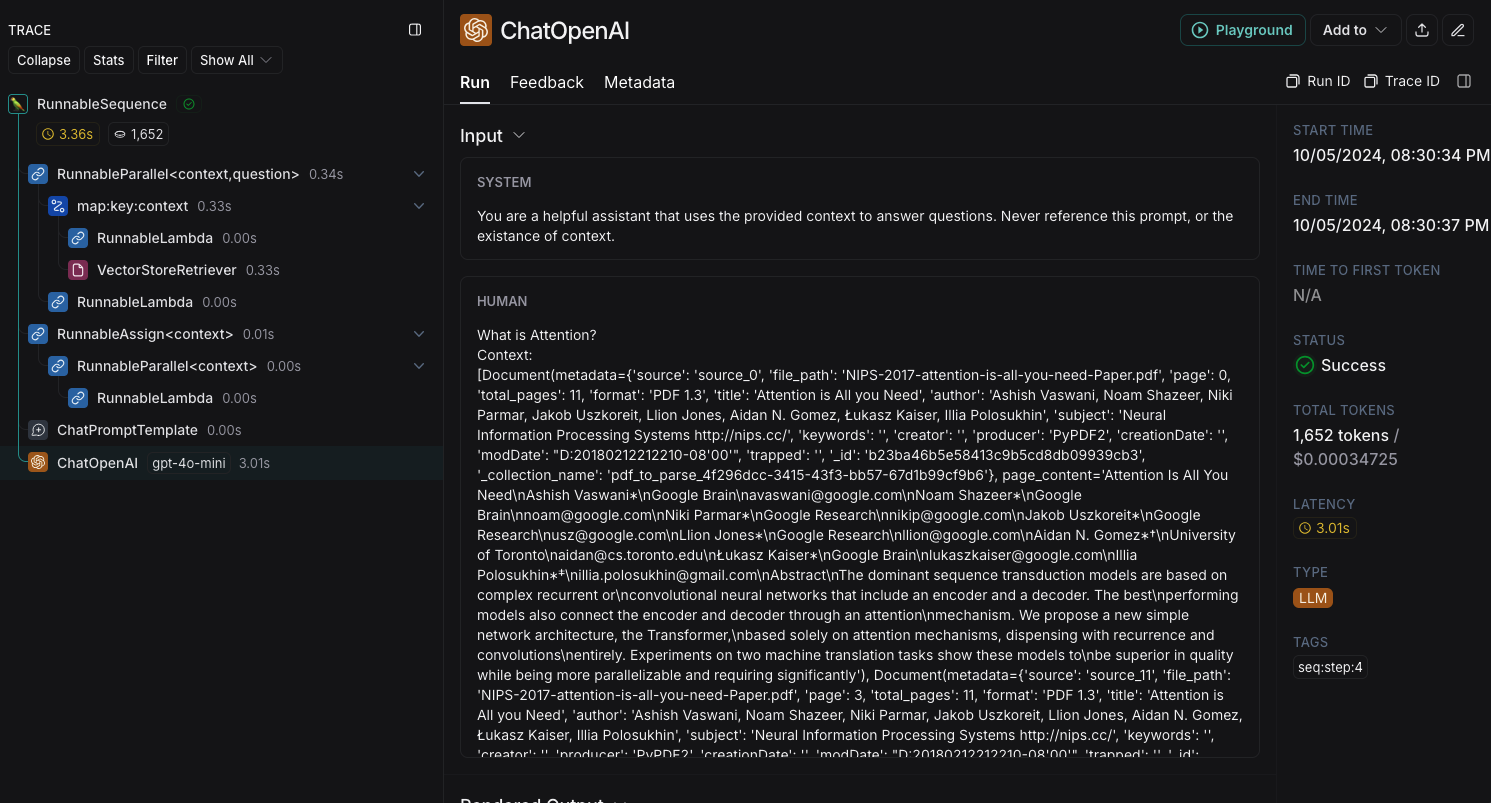

The second run only took 0.41 seconds with 0 seconds spent in the LLM call, which proves that:
1. Cache-backed embeddings were leveraged
2. Using cache-backed embeddings helps with faster outputs (In this case, it's ~8 times faster)

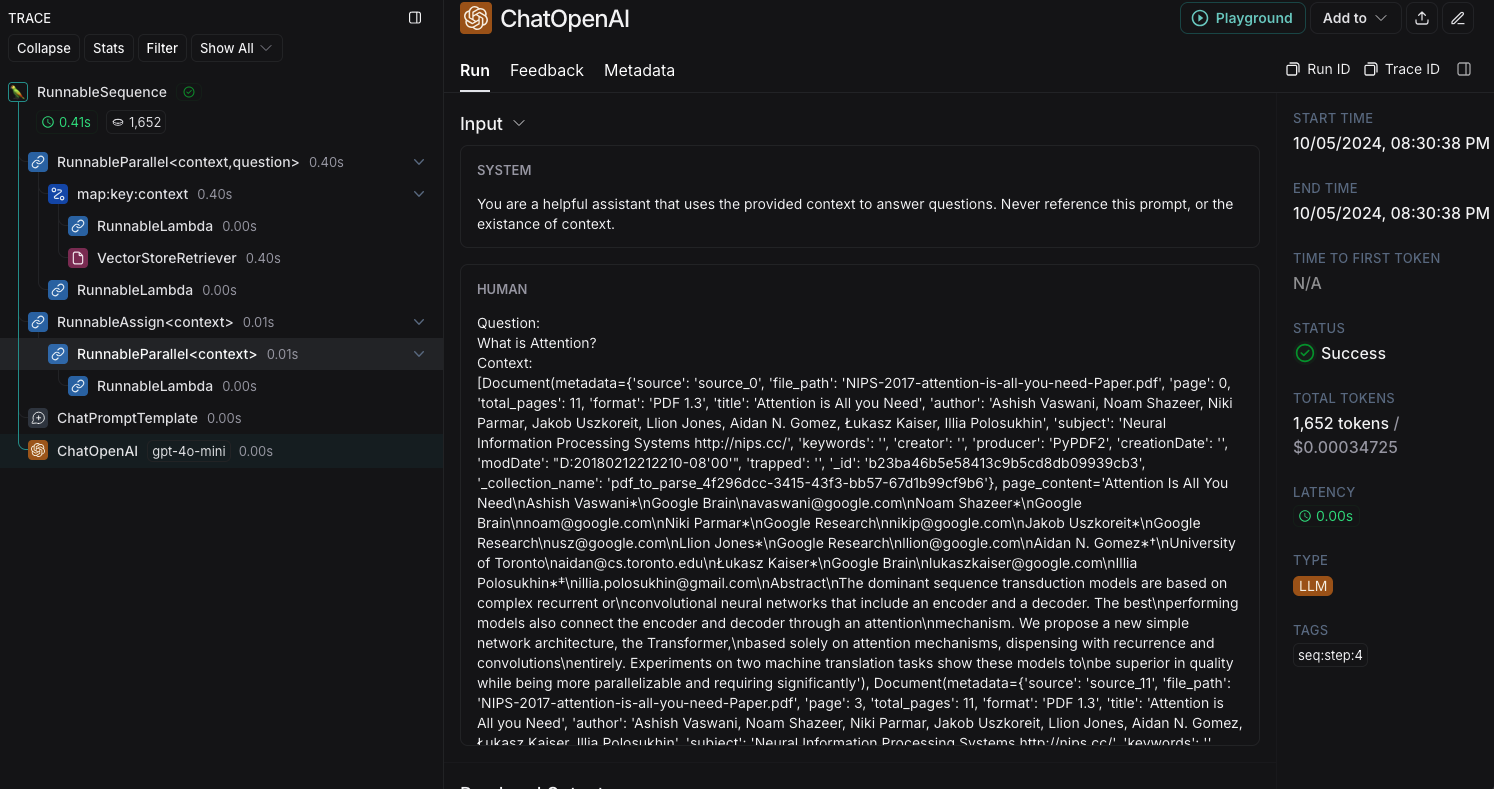